Primary data:
      Holiday_Flag  Temperature_Celsius  Fuel_Price  Unemployment  \
0                0                 5.73       2.572         8.106   
1                1                 3.62       2.548         8.106   
2                0                 4.41       2.514         8.106   
3                0                 8.13       2.561         8.106   
4                0                 8.06       2.625         8.106   
...            ...                  ...         ...           ...   
6430             0                18.27       3.997         8.684   
6431             0                18.27       3.985         8.667   
6432             0                12.48       4.000         8.667   
6433             0                13.59       3.969         8.667   
6434             0                14.92       3.882         8.667   

     Weekly_Sales  Month  
0          Medium      2  
1          Medium      2  
2          Medium      2  
3          Medium      2  
4          Medium     

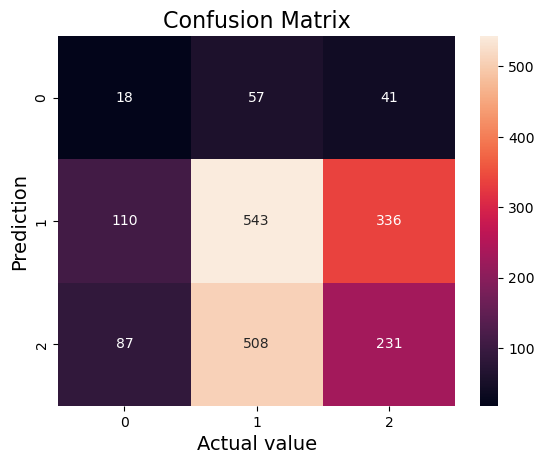

Depth 3 accuracy: 58.21% (Time taken: 0.01 seconds)
Depth 5 accuracy: 57.38% (Time taken: 0.01 seconds)
Depth 7 accuracy: 55.46% (Time taken: 0.01 seconds)
Depth 10 accuracy: 60.07% (Time taken: 0.01 seconds)

 *** Random forest test:
Random forest trees count = 5:
Accuracy: 46.92 %
Mean Absolute Error:  0.5624
Mean Squared Error:  0.6256


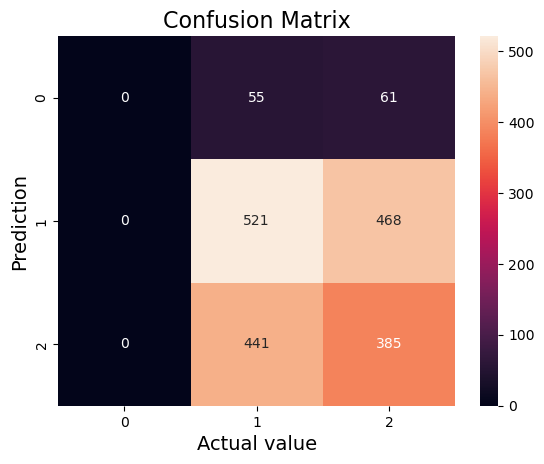

In [29]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
import graphviz
import plotly.graph_objs as go
import time

class TaskUtils:
    def readData(data):
        df = pd.read_csv(data)
        df = TaskUtils.formatData(df)
        print("Primary data:")
        print(df)
        print("\n")
        return df
        
    def formatData(data):
        # Assuming data is your DataFrame
        data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
        data['Month'] = data['Date'].dt.month
        data = data.drop(columns=['Date'])
        data['Weekly_Sales'] = pd.cut(data['Weekly_Sales'], 
                              bins=[0, 1000000,  2000000, float('inf')], 
                              labels=['Low', 'Medium', 'High'])
        return data

    def encodePredictionAttribute(data):
        # Prediction (target) attribute - Weekly_Sales
        X = data.drop("Weekly_Sales", axis=1)
        y = data["Weekly_Sales"]      
        # Encode target value as integer
        encoder = LabelEncoder() 
        y = encoder.fit_transform(y)
        return X, y

    def teachAndTestSplit(data, testsize, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testsize, random_state = 42)
        return X_train, X_test, y_train, y_test

    def formatDecisionTree(X_train, X_test, y_train):
        # Format categorical values
        encoder = LabelEncoder()
        X_train = X_train.apply(encoder.fit_transform) 
        X_test = X_test.apply(encoder.fit_transform)             
        # Create decision tree model using Gini
        clf = DecisionTreeClassifier(criterion="gini", random_state=42)
        # Learn
        clf.fit(X_train, y_train)
        return clf

    def visualizeDecisionTree(data, X, y, clf):
        unique_classes = np.unique(y) # get unique values
        str_unique_classes = [str(x) for x in unique_classes] # Convert unique values into string values
        dot_data = export_graphviz(clf, out_file=None, feature_names=X.columns, class_names = str_unique_classes , filled=True, rounded=True, special_characters=True) 
        graph = graphviz.Source(dot_data)
        graph.render("decision_tree")          
        plt.figure(figsize =(50,50))
        plot_tree(clf, filled= True, rounded= True, class_names= ['Low', 'Medium', 'High'], feature_names= X.columns)
        plt.show()

    def predictTestData(clf, X_test):
        y_pred = clf.predict(X_test) # make a prediction
        np.set_printoptions(threshold=np.inf) 
        print("Predicted test data:\n", y_pred)
        return y_pred
        
    def accuracy(y_test, y_pred):        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy * 100 :.2f} %")

    def errors(y_test, y_pred):
        mae = mean_absolute_error(y_test, y_pred) 
        mse = mean_squared_error(y_test, y_pred)
        rse = r2_score (y_test, y_pred)
        print(f"Mean Absolute Error: {mae: .4f}")
        print(f"Mean Squared Error: {mse: .4f}")

    def confussionMatrix(y_test, y_pred):
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt="g")
        plt.title("Confusion Matrix", fontsize=16)
        plt.ylabel("Prediction", fontsize=14)
        plt.xlabel("Actual value",fontsize=14)
        plt.show()

    def variousDepthTree(X_test, X_train, y_test, y_train, depths):
        for depth in depths:
            start_time = time.time()       
            clf_depth = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=depth)
            clf_depth.fit(X_train, y_train)
            y_pred = clf_depth.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)         
            end_time = time.time()
            elapsed_time = end_time - start_time            
            print(f"Depth {depth} accuracy: {accuracy * 100:.2f}% (Time taken: {elapsed_time:.2f} seconds)")

    def formatRandomForest(X_train, X_test, y_train, treesCount, maxDepth):
        encoder = LabelEncoder()
        X_train = X_train.apply(encoder.fit_transform) 
        X_test = X_test.apply(encoder.fit_transform)             
        forest = RandomForestClassifier(n_estimators=treesCount, max_depth=maxDepth, random_state=42)
        # Learn
        forest.fit(X_train, y_train)
        return forest

    def testRandomForest(y_test, y_pred_forest, treesCount):
        print("\n *** Random forest test:")
        forest_accuracy = accuracy_score(y_test, y_pred_forest)
        print(f"Random forest trees count = {treesCount}:")
        TaskUtils.accuracy(y_test, y_pred_forest)
        TaskUtils.errors(y_test, y_pred_forest)
        TaskUtils.confussionMatrix(y_test, y_pred_forest)

def main():
    # 1. Select dataset
    data = "Sales_data.csv"
    data = TaskUtils.readData(data)

    # 2. Select prediction attribute
    X, y = TaskUtils.encodePredictionAttribute(data)

    # 3-4. Datasplit for test and teach
    testsize = 0.3
    X_train, X_test, y_train, y_test = TaskUtils.teachAndTestSplit(data, testsize, X, y)

    # 5. Format decision tree
    clf = TaskUtils.formatDecisionTree(X_train, X_test, y_train)
    depthInitial = clf.get_depth()
    print("Depth of the Decision Tree:", depthInitial)

    # 6. Visualize decision tree
    TaskUtils.visualizeDecisionTree(data, X, y, clf)

    # 7. Testing decision tree
    y_pred = TaskUtils.predictTestData(clf, X_test)
    print("\n *** Decision tree test:")
    TaskUtils.accuracy(y_test, y_pred)
    TaskUtils.errors(y_test, y_pred)
    TaskUtils.confussionMatrix(y_test, y_pred)

    # 8. Different depth of tree test
    depths = [3, 5, 7, 10]
    TaskUtils.variousDepthTree(X_test, X_train, y_test, y_train, depths)

    # 9-10. Format random forest
    treesCount = 5 # also from 3 to 9
    maxDepth = 10
    forest = TaskUtils.formatRandomForest(X_train, X_test, y_train, treesCount, maxDepth)

    # Testing random forest
    y_pred_forest = forest.predict(X_test)
    TaskUtils.testRandomForest(y_test, y_pred_forest, treesCount)

if __name__ == "__main__":
    main()
    

